In [1]:
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


The following cell holds the definition of our parameters, these values can be overriden by rendering the with e.g. the following command:

papermill -p alpha 0.2 -p ratio 0.3 universe_analysis.ipynb output/test_run.ipynb

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


In [3]:
run_no = 0
universe_id = "test"
universe = {
    "training_size": "25k", # "25k", "5k", "1k"
    "training_year": "2014", # "2014", "2012_14", "2010_14"
    "scale": "scale", # "scale", "do-not-scale",
    #"stratify_split": "target", # "none", "target", "protected-attribute", "both",
    "model": "elasticnet", # "logreg", "penalized_logreg", "rf", "gbm", "elasticnet"
    "cutoff": ["quantile_0.15", "quantile_0.30"],
    "exclude_features": "age", # "none", "nationality", "sex", "nationality-sex", "age"
    "exclude_subgroups": "keep-all", # "keep-all", "drop-non-german"
    "eval_fairness_grouping": ["majority-minority", "nationality-all"]
}

output_dir="./output"
seed=0

In [4]:
# Parameters
universe_id = "28e8318163e778a98297f2792f73e3af"
run_no = "14"
universe = "{\"cutoff\": [\"quantile_0.1\", \"quantile_0.25\"], \"eval_fairness_grouping\": [\"majority-minority\", \"nationality-all\"], \"exclude_features\": \"sex\", \"exclude_subgroups\": \"keep-all\", \"model\": \"elasticnet\", \"scale\": \"scale\", \"training_size\": \"5k\", \"training_year\": \"2014\"}"
output_dir = "output"
seed = "2023"


In [5]:
import json
# Parse universe into dict if it is passed as a string
if isinstance(universe, str):
    universe = json.loads(universe)

In [6]:
# Auto-reload the custom package
%load_ext autoreload
%autoreload 1
%aimport fairness_multiverse

In [7]:
from fairness_multiverse.universe import UniverseAnalysis

universe_analysis = UniverseAnalysis(
    run_no = run_no,
    universe_id = universe_id,
    universe = universe,
    output_dir=output_dir,
)

In [8]:
import numpy as np
parsed_seed = int(seed)
np.random.seed(parsed_seed)
print(f"Using Seed: {parsed_seed}")

Using Seed: 2023


# Loading Data

Load siab_train, siab_test, siab_calib and/or 
load siab_train_features, siab_train_labels

In [9]:
from pathlib import Path
import pandas as pd

# File paths
raw_file = Path("data/raw/siab.csv")
cache_file = Path("data/siab_cached.csv.gz")

# Ensure cache directory exists
cache_file.parent.mkdir(parents=True, exist_ok=True)

# Load with simple caching
if cache_file.exists():
    print(f"Loading SIAB data from cache: {cache_file}")
    siab = pd.read_csv(cache_file, compression='gzip')
else:
    print(f"Cache not found. Reading raw SIAB data: {raw_file}")
    siab = pd.read_csv(raw_file)
    siab.to_csv(cache_file, index=False, compression='gzip')
    print(f"Cached SIAB data to: {cache_file}")

# Now use `siab` DataFrame as needed
print(siab.shape)

Loading SIAB data from cache: data/siab_cached.csv.gz


(643690, 164)


In [10]:
#siab

In [11]:
#import pandas as pd
#
#X_train = pd.read_csv("./data/X_train.csv")
#y_train = pd.read_csv("./data/y_train.csv")

In [12]:
#X_test = pd.read_csv("./data/X_test.csv")
#y_true = pd.read_csv("./data/y_test.csv")

In [13]:
# Calibration data for conformal
#X_calib = pd.read_csv("./data/X_calib.csv")
#y_calib = pd.read_csv("./data/y_calib.csv")

# Splitting Data and Setting Training Data Size

In [14]:
def sample_by_year_size(df,
                        training_year: str,
                        training_size: str,
                        random_state: int = 42):
    # --- parse training_year into a list of int years ---
    if "_" in training_year:
        start_str, end_str = training_year.split("_", 1)
        start = int(start_str)
        end   = int(end_str) if len(end_str) == 4 else (int(end_str) + (start // 100)*100)
        years = list(range(start, end + 1))
    else:
        years = [int(training_year)]

    df = df[df["year"].isin(years)].reset_index(drop=True)

    # --- map training_size to total number of samples ---
    total_map = {"25k": 25_000, "5k": 5_000, "1k": 1_000}
    if training_size not in total_map:
        return df  # e.g. "all"

    total_samples = total_map[training_size]
    n_years       = len(years)
    base          = total_samples // n_years
    remainder     = total_samples % n_years

    # --- build a dict: year -> how many to sample ---
    # give +1 to the first `remainder` years in ascending order
    quotas = {
        year: base + (1 if idx < remainder else 0)
        for idx, year in enumerate(sorted(years))
    }

    # --- sample per‐year according to the quota dict ---
    sampled = (
        df
        .groupby("year", group_keys=False)
        .apply(lambda grp: grp.sample(
            n=min(len(grp), quotas[grp.name]),
            random_state=random_state))
        .reset_index(drop=True)
    )

    return sampled

In [15]:
#universe["training_size"]

In [16]:
#universe["training_year"]

In [17]:
siab_train = sample_by_year_size(siab,
                               training_year=universe["training_year"],
                               training_size=universe["training_size"])

In [18]:
#siab_train.shape

In [19]:
#display(siab_train.groupby("year").size())

In [20]:
#siab_train = siab_s[siab_s.year < 2015]
siab_calib = siab[siab.year == 2015]
siab_test = siab[siab.year == 2016]

In [21]:
X_train = siab_train.iloc[:,4:164]
y_train = siab_train.iloc[:, [3]]

In [22]:
X_calib = siab_calib.iloc[:,4:164]
y_calib = siab_calib.iloc[:, [3]]

In [23]:
X_test = siab_test.iloc[:,4:164]
y_true = siab_test.iloc[:, [3]]

# Splitting Data and Setting Training Data Size OLD VERSION

In [24]:
#def sample_by_year(df, training_size, random_state=42):
#    if training_size == "2014":
#        return df[df["year"] == 2014].reset_index(drop=True)
#    
#    size_map = {
#        "25k": 5000,
#        "5k": 1000,
#        "1k": 200
#    }
#
#    if training_size not in size_map:
#        return df.reset_index(drop=True)  # use all data
#
#    n_per_year = size_map[training_size]
#    grouped = df.groupby("year")
#    sampled = grouped.apply(lambda x: x.sample(n=min(n_per_year, len(x)), random_state=random_state))
#    return sampled.reset_index(drop=True)

In [25]:
#siab_s = sample_by_year(siab, universe["training_size"])

In [26]:
#display(siab_s.groupby("year").size())

In [27]:
# Auxiliary data needed downstream in the pipeline

org_train = X_train.copy()
org_test = X_test.copy()
org_calib = X_calib.copy()

In [28]:
# put in other script?
# Group sizes

#def calculate_percentages(df, df_name):
#    total_entries = len(df)
#
#    female_pct = (df['frau1'] == 1).mean() * 100
#    non_german_pct = ((df['maxdeutsch1'] == 0) & (df['maxdeutsch.Missing.'] == 0)).mean() * 100
#    non_german_male_pct = ((df['frau1'] == 0) & (df['maxdeutsch1'] == 0) & (df['maxdeutsch.Missing.'] == 0)).mean() * 100
#    non_german_female_pct = ((df['frau1'] == 1) & (df['maxdeutsch1'] == 0) & (df['maxdeutsch.Missing.'] == 0)).mean() * 100
#
#    print(f"--- {df_name} ---")
#    print(f"Female: {female_pct:.2f}%")
#    print(f"Non-German: {non_german_pct:.2f}%")
#    print(f"Non-German Male: {non_german_male_pct:.2f}%")
#    print(f"Non-German Female: {non_german_female_pct:.2f}%\n")
#
## Calculate for each DataFrame
#calculate_percentages(siab_calib, "siab_calib")
#calculate_percentages(siab_test, "siab_test")
#calculate_percentages(siab_train, "siab_train")

# Preprocessing Data

In [29]:
# EXCLUDE PROTECTED FEATURES
# ----------------------
# "exclude_features": "none", # "nationality", "sex", "nationality-sex"

excluded_features = universe["exclude_features"].split("-") # split, e.g.: "nationality-sex" -> ["nationality", "sex"]
excluded_features_dictionary = {
    "nationality": ["maxdeutsch1", "maxdeutsch.Missing."],
    "sex": ["frau1"],
    "age": ["age"],
}


In [30]:
# Code nice names to column names

excluded_features_columns = [
    excluded_features_dictionary[f] for f in excluded_features if len(f) > 0 and f != "none"
]

In [31]:
from utils import flatten_once

excluded_features_columns = flatten_once(excluded_features_columns)

In [32]:
if len(excluded_features_columns) > 0:
    print(f"Dropping features: {excluded_features_columns}")
    X_train.drop(excluded_features_columns, axis=1, inplace=True)

Dropping features: ['frau1']


In [33]:
if len(excluded_features_columns) > 0:
    print(f"Dropping features: {excluded_features_columns}")
    X_test.drop(excluded_features_columns, axis=1, inplace=True)

Dropping features: ['frau1']


In [34]:
if len(excluded_features_columns) > 0:
    print(f"Dropping features: {excluded_features_columns}")
    X_calib.drop(excluded_features_columns, axis=1, inplace=True)

Dropping features: ['frau1']


In [35]:
# SPLIT & STRATIFY DATA
# ----------------------

In [36]:
# EXCLUDE CERTAIN SUBGROUPS
# ----------------------

mode = universe.get("exclude_subgroups", "keep-all") 
# Fetches the exclude_subgroups setting from the universe dict.
# Defaults to "keep-all" if the key is missing.

In [37]:
if mode == "keep-all":
    keep_mask = pd.Series(True, index=org_train.index)

# org_train contains the original feature columns from features_org (in Simson)
# features_org contains unprocessed features, for me X_train at beginning ???
# For keep-all, creates a boolean Series (keep_mask) of all True, so no rows are removed.

elif mode == "drop-non-german":
    keep_mask = org_train["maxdeutsch1"] == 1 # ??? what about missing values?

else:
    raise ValueError(f"Unsupported mode for exclude_subgroups: {mode}")


In [38]:
n_drop = (~keep_mask).sum() # Calculates how many rows are set to be dropped
if n_drop > 0:
    pct = n_drop / len(keep_mask) * 100
    print(f"Dropping {n_drop} rows ({pct:.2f}%) where mode='{mode}'")

In [39]:
X_train = X_train[keep_mask]

In [40]:
y_train = y_train[keep_mask]

# Model Training

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

if (universe["model"] == "logreg"):
    model = LogisticRegression() #penalty="none") #, solver="newton-cg", max_iter=1) # include random_state=19 ?
elif (universe["model"] == "penalized_logreg"):
    model = LogisticRegression(penalty="l2", C=1.0) #, solver="newton-cg", max_iter=1)
elif (universe["model"] == "rf"):
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
elif (universe["model"] == "gbm"):
    model = GradientBoostingClassifier()
elif (universe["model"] == "elasticnet"):
    model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, max_iter=5000) # which solver to use?
else:
    raise "Unsupported universe.model"

In [42]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    #("continuous_processor", continuous_processor),
    #("categorical_preprocessor", categorical_preprocessor),
    ("scale", StandardScaler() if universe["scale"] == "scale" else None), 
    ("model", model),
])

In [43]:
model.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 LogisticRegression(l1_ratio=0.5, max_iter=5000,
                                    penalty='elasticnet', solver='saga'))])

In [44]:
from fairness_multiverse.universe import predict_w_threshold

In [45]:
probs_test = model.predict_proba(X_test)

'''
Below code returns a boolean array (or binary 0/1 array depending on how it’s used) where each element 
is True if the probability of class 1 is greater than or equal to the threshold, and False otherwise.
'''
y_pred_default = predict_w_threshold(probs_test, 0.5)

from sklearn.metrics import accuracy_score

# Naive prediction
accuracy_score(y_true = y_true, y_pred = y_pred_default)

0.8579199643295062

In [46]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

# Conformal Prediction

In [47]:
# Miscoverage level for conformal prediction (10% allowed error rate => 90% target coverage)
alpha = 0.1

In [48]:
probs_calib = model.predict_proba(X_calib)

In [49]:
y_calib = y_calib.values.ravel().astype(int)

In [50]:
from fairness_multiverse.conformal import compute_nc_scores

# Compute nonconformity scores on calibration set (1 - probability of true class)
nc_scores = compute_nc_scores(probs_calib, y_calib)

In [51]:
from fairness_multiverse.conformal import find_threshold

# Find conformal threshold q_hat for the given alpha (split conformal method)
q_hat = find_threshold(nc_scores, alpha)

In [52]:
q_hat

0.6841418850124528

In [53]:
from fairness_multiverse.conformal import predict_conformal_sets

# Generate prediction sets for each test example
pred_sets = predict_conformal_sets(model, X_test, q_hat)

In [54]:
y_true = y_true.squeeze()

In [55]:
from fairness_multiverse.conformal import evaluate_sets

# Evaluate coverage and average set size on test data
metrics = evaluate_sets(pred_sets, y_true)

# CP Metrics

In [56]:
metrics

{'coverage': 0.9104336194404191, 'avg_size': 1.1339204102106788}

In [57]:
example_universe = universe.copy()
universe_training_year = example_universe.get("training_year")
universe_training_size = example_universe.get("training_size")
universe_scale = example_universe.get("scale")
universe_model = example_universe.get("model")
universe_exclude_features = example_universe.get("exclude_features")
universe_exclude_subgroups = example_universe.get("exclude_subgroups")

In [58]:
cp_metrics_dict = {
    "universe_id": [universe_id],
    "universe_training_year": [universe_training_year],
    "universe_training_size": [universe_training_size],
    "universe_scale": [universe_scale],
    "universe_model": [universe_model],
    "universe_exclude_features": [universe_exclude_features],
    "universe_exclude_subgroups": [universe_exclude_subgroups],
    "q_hat": [q_hat],
    "coverage": [metrics["coverage"]],
    "avg_size": [metrics["avg_size"]],
}

In [59]:
cp_metrics_dict

{'universe_id': ['28e8318163e778a98297f2792f73e3af'],
 'universe_training_year': ['2014'],
 'universe_training_size': ['5k'],
 'universe_scale': ['scale'],
 'universe_model': ['elasticnet'],
 'universe_exclude_features': ['sex'],
 'universe_exclude_subgroups': ['keep-all'],
 'q_hat': [0.6841418850124528],
 'coverage': [0.9104336194404191],
 'avg_size': [1.1339204102106788]}

In [60]:
cp_metrics_df = pd.DataFrame(cp_metrics_dict)

In [61]:
cp_metrics_df

,universe_id,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size
0,28e8318163e778a98297f2792f73e3af,2014,5k,scale,elasticnet,sex,keep-all,0.684142,0.910434,1.13392


In [62]:
# Conditional Coverage & looking at subgroups

In [63]:
from fairness_multiverse.conformal import build_cp_groups

cp_groups_df = build_cp_groups(pred_sets, y_true, X_test.index, org_test)
#needs universe_id and setting

In [64]:
#delete
#cp_groups_df

In [65]:
#delete
#percentage = (cp_groups_df['nongerman_female'] == 1).mean() * 100
#print(percentage)


In [66]:
# Define covered = 1 if true_label is in the predicted set
cp_groups_df['covered'] = cp_groups_df.apply(
    lambda r: int(r['true_label'] in r['pred_set']),
    axis=1
)

In [67]:
#cp_groups_df

In [68]:
subgroups = ['frau1','nongerman','nongerman_male','nongerman_female']

# Conditional coverage for subgroup==1
cond_coverage = {
    g: cp_groups_df.loc[cp_groups_df[g]==1, 'covered'].mean()
    for g in subgroups
}

In [69]:
cond_coverage

{'frau1': 0.9096374174417038,
 'nongerman': 0.9104586537921743,
 'nongerman_male': 0.9274970728631902,
 'nongerman_female': 0.8822652757078987}

In [70]:
for subgroup, cov in cond_coverage.items():
    cp_metrics_df[f"cov_{subgroup}"] = cov

In [71]:
cp_metrics_df

,universe_id,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,28e8318163e778a98297f2792f73e3af,2014,5k,scale,elasticnet,sex,keep-all,0.684142,0.910434,1.13392,0.909637,0.910459,0.927497,0.882265


# (Fairness) Metrics

In [72]:
# do I need to include maxdeutsch1.missing?

import numpy as np

colname_to_bin = "maxdeutsch1"
majority_value = org_train[colname_to_bin].mode()[0]

org_test["majmin"] = np.where(org_test[colname_to_bin] == majority_value, "majority", "minority")

In [73]:
example_universe = universe.copy()
example_universe["cutoff"] = example_universe["cutoff"][0]
example_universe["eval_fairness_grouping"] = example_universe["eval_fairness_grouping"][0]
fairness_dict, metric_frame = universe_analysis.compute_metrics(
    example_universe,
    y_pred_prob=probs_test,
    y_test=y_true,
    org_test=org_test,
)

# Overall

Fairness
Main fairness target: Equalized Odds. Seems to be a better fit than equal opportunity, since we're not only interested in Y = 1. Seems to be a better fit than demographic parity, since we also care about accuracy, not just equal distribution of preds.

Pick column for computation of fairness metrics

Performance
Overall performance measures, most interesting in relation to the measures split by group below

In [74]:
metric_frame.overall

accuracy                   0.224312
balanced accuracy          0.548486
f1                         0.245645
precision                  0.140329
false positive rate        0.887560
false negative rate        0.015468
selection rate             0.900000
count                  89710.000000
dtype: float64

By Group

In [75]:
metric_frame.by_group

,accuracy,balanced accuracy,f1,precision,false positive rate,false negative rate,selection rate,count
majmin,,,,,,,,
majority,0.242330,0.556853,0.255589,0.146861,0.870648,0.015646,0.885673,69170.0
minority,0.163632,0.520895,0.213596,0.119782,0.943429,0.014780,0.948247,20540.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='majmin'>,
        <Axes: title={'center': 'balanced accuracy'}, xlabel='majmin'>,
        <Axes: title={'center': 'f1'}, xlabel='majmin'>],
       [<Axes: title={'center': 'precision'}, xlabel='majmin'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='majmin'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='majmin'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='majmin'>,
        <Axes: title={'center': 'count'}, xlabel='majmin'>,
        <Axes: xlabel='majmin'>]], dtype=object)

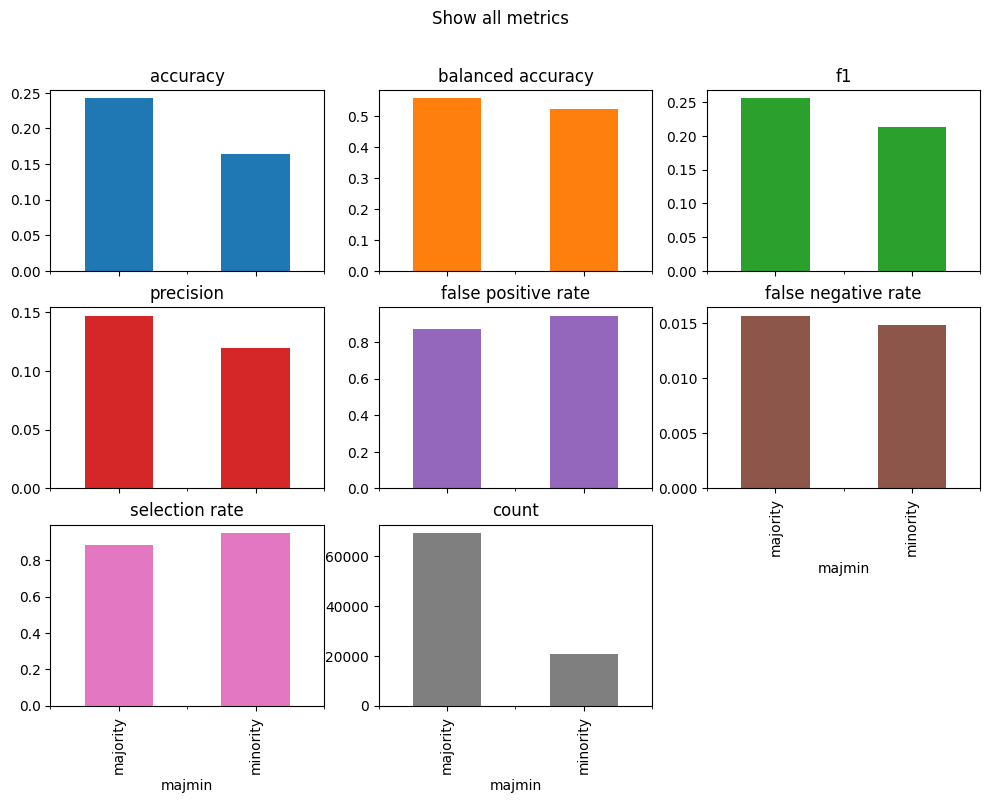

In [76]:
# In a graphic
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Final Output

In [77]:
sub_universes = universe_analysis.generate_sub_universes()
len(sub_universes)

4

In [78]:
def filter_sub_universe_data(sub_universe, org_test):
    # Keep all rows — no filtering
    keep_rows_mask = np.ones(org_test.shape[0], dtype=bool)

    print(f"[INFO] Keeping all rows: {keep_rows_mask.sum()} rows retained.")
    return keep_rows_mask

In [79]:
final_output = universe_analysis.generate_final_output(
    y_pred_prob=probs_test,
    y_test=y_true,
    org_test=org_test,
    filter_data=filter_sub_universe_data,
    cp_metrics_df=cp_metrics_df,
    save=True,
)
final_output

Stopping execution_time clock.
[INFO] Keeping all rows: 89710 rows retained.


[INFO] Keeping all rows: 89710 rows retained.


[INFO] Keeping all rows: 89710 rows retained.


[INFO] Keeping all rows: 89710 rows retained.


,run_no,universe_id,universe_settings,execution_time,test_size_n,test_size_frac,fair_main_equalized_odds_difference,fair_main_equalized_odds_ratio,fair_main_demographic_parity_difference,fair_main_demographic_parity_ratio,...,perf_grp_precision_0,perf_grp_precision_1,perf_grp_false positive rate_0,perf_grp_false positive rate_1,perf_grp_false negative rate_0,perf_grp_false negative rate_1,perf_grp_selection rate_0,perf_grp_selection rate_1,perf_grp_count_0,perf_grp_count_1
0,14,28e8318163e778a98297f2792f73e3af,"{""cutoff"": ""quantile_0.1"", ""eval_fairness_grou...",36.368305,89710,1.0,0.072781,0.922854,0.062574,0.934011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,14,28e8318163e778a98297f2792f73e3af,"{""cutoff"": ""quantile_0.1"", ""eval_fairness_grou...",36.368305,89710,1.0,0.072781,0.922854,0.062574,0.934011,...,0.119782,0.146861,0.943429,0.870648,0.014780,0.015646,0.948247,0.885673,20540.0,69170.0
0,14,28e8318163e778a98297f2792f73e3af,"{""cutoff"": ""quantile_0.25"", ""eval_fairness_gro...",36.368305,89710,1.0,0.148541,0.822404,0.128566,0.848590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,14,28e8318163e778a98297f2792f73e3af,"{""cutoff"": ""quantile_0.25"", ""eval_fairness_gro...",36.368305,89710,1.0,0.148541,0.822404,0.128566,0.848590,...,0.128548,0.171525,0.836397,0.687856,0.053209,0.064661,0.849124,0.720558,20540.0,69170.0
